# LauzHack - 2024 
## Team Andy
> Members: Neel Lodha, Manu Gautam, Sagar Chethan Kumar, Atilla Colak

In [360]:
import polars as pl
import numpy as np
import itertools

df_account_booking_train = pl.read_csv('data/account_booking_train.csv')
df_account_booking_test = pl.read_csv('data/account_booking_test.csv')
df_external_parties_train = pl.read_csv('data/external_parties_train.csv')
df_external_parties_test = pl.read_csv('data/external_parties_test.csv')

print('Booking keys: ', df_account_booking_train.columns)
print('External parties keys', df_external_parties_train.columns)

Booking keys:  ['transaction_reference_id', 'debit_credit_indicator', 'account_id', 'transaction_amount', 'transaction_currency', 'transaction_date']
External parties keys ['transaction_reference_id', 'party_role', 'party_info_unstructured', 'parsed_name', 'parsed_address_street_name', 'parsed_address_street_number', 'parsed_address_unit', 'parsed_address_postal_code', 'parsed_address_city', 'parsed_address_state', 'parsed_address_country', 'party_iban', 'party_phone', 'external_id']


If a transaction has two legs (i.e., two rows in the table), it represents an internal transaction between two UBS accounts and is out of scope for this challenge. Only transactions with one leg (i.e., involving a single external party) are relevant for the task of entity resolution. Therefore, we filter them out here

In [352]:
def remove_duplicates(df_account_booking: pl.DataFrame, df_external_parties: pl.DataFrame) -> pl.DataFrame:
    # Count occurrences of transaction_reference_id
    repeat_ids = (
        df_account_booking
        .group_by('transaction_reference_id')
        .agg(pl.len().alias('count'))
        .filter(pl.col('count') > 1)
        .select('transaction_reference_id')
    )
    
    # Remove rows with duplicate transaction_reference_id
    df_account_booking = df_account_booking.filter(
        ~pl.col('transaction_reference_id').is_in(repeat_ids)
    )
    
    # Join external parties data
    df = df_account_booking.join(
        df_external_parties, 
        on='transaction_reference_id', 
        how='left'
    )
    
    return df

In [353]:
features = ['transaction_reference_id', 'parsed_name', 'party_iban', 'parsed_address_postal_code', 'parsed_address_city', 'parsed_address_country', 'party_info_unstructured']

df_train: pl.DataFrame = remove_duplicates(df_account_booking_train, df_external_parties_train)
df_test: pl.DataFrame = remove_duplicates(df_account_booking_test, df_external_parties_test)

print(df_train.shape)
print(df_test.shape)
display(df_train.columns)

(11064, 19)
(1481672, 18)


['transaction_reference_id',
 'debit_credit_indicator',
 'account_id',
 'transaction_amount',
 'transaction_currency',
 'transaction_date',
 'party_role',
 'party_info_unstructured',
 'parsed_name',
 'parsed_address_street_name',
 'parsed_address_street_number',
 'parsed_address_unit',
 'parsed_address_postal_code',
 'parsed_address_city',
 'parsed_address_state',
 'parsed_address_country',
 'party_iban',
 'party_phone',
 'external_id']

# Exploratory Data Analysis
In order to understand the distribution of the dataset and the heuristics that could be applied to it, here we visualize the distribution of the data and identify key discriminative features that can be used to cluster.

In [330]:
df_test.group_by(pl.col('parsed_name')).agg(pl.len().alias('count')).sort(pl.col('count'))

parsed_name,count
str,u32
"""taylor-conley inc.""",1
"""mr. tracey bbennett""",1
"""strickland, frederick and bell""",1
"""jamesramirez""",1
"""martinez-johmson int.""",1
"""williams grop""",1
"""hammond-winters""",1
"""torres-bradley""",1
"""nichols inc ibc""",1


In [331]:
df_test.filter(pl.col('parsed_name').eq('smith group'))

transaction_reference_id,debit_credit_indicator,account_id,transaction_amount,transaction_currency,transaction_date,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone
str,str,i64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""1f553461490eb1ddc73eaa40cd6b58a8""","""CREDIT""",13369,8068.53,"""GBP""","""2024-01-31""","""ORG""","""smith group 16856 hanson manor apt. 076 jessicabury riosshire 14067 marshall islands""","""smith group""","""hanson manor""","""16856""",null,"""14067""","""jessicabury riosshire marshall""",null,"""islands""","""GB24PJPE45944632047725""","""+41(511)496-43134011"""
"""84e1e8dca58c338dff5798d1c610a124""","""CREDIT""",10616,8511.17,"""GBP""","""2024-10-22""","""ORG""","""smith group 238 pamela plaza suite 005 christopherville new levi 66341 portugel""","""smith group""","""pamela plaza suite 005""","""238""",null,"""66341""","""christopherville new levi portugel""",null,null,null,""" 233347-1487x410"""
"""1632c5f4759e04c27957100240b0159c""","""CREDIT""",14901,5342.21,"""GBP""","""2024-05-31""","""ORG""","""smith group 03/07/1989 95941 snow plains lake carolyn brownstad 43273 australia""","""smith group""","""snow plains lake""",null,null,"""95941 43273""","""carolyn brownstad""",null,"""australia""","""GB36UDPA69319976774027""",null
"""fdf8f4cf44a7d969effb1f9ec29567e7""","""CREDIT""",17013,2225.41,"""GBP""","""2022-12-07""","""ORG""","""smith group 8449 bishop mill apt. 512 johnstad 57554 tajikistan""","""smith group""","""bishop mill apt.""","""8449 512""",null,"""57554""","""johnstad""",null,"""tajikistan""","""GB58FPME85302204005450""",null
"""363a5fdc4d81eef5c55922ee30c875e7""","""CREDIT""",13350,9297.38,"""GBP""","""2023-06-15""","""ORG""","""smith group 549 cannon overpass pamelabury lake kaylamouth 74358 morocco""","""smith group""","""cannon overpass pamelabury lake""","""549""",null,"""74358""","""kaylamouth""",null,"""morocco""","""GB73FAKQ79182793397612""","""(+41) +1-267-867 -262524220"""
"""512c026686e3d20879ebc2da6884a713""","""DEBIT""",13655,9169.77,"""GBP""","""2024-01-19""","""BENE""","""smith group 45441 ukraine""","""smith group""",null,null,null,"""45441""",null,null,"""ukraine""",null,null
"""4d81815386c29c50a6c3701e6f9efcbd""","""CREDIT""",11679,7491.54,"""GBP""","""2024-08-11""","""ORG""","""smith group 376 williams circle apt. 955 76465""","""smith group""","""williams circle""","""376""",null,"""76465""",null,"""apt.""",null,"""GB43YODF32682050230548""","""+30 +1-485602-116710220"""
"""39266d56f521478dfe9a9edf8d5cb173""","""CREDIT""",19999,7079.9,"""GBP""","""2023-10-02""","""ORG""","""smith group 52778 csmbodia""","""smith group""",null,null,null,"""52778""","""csmbodia""",null,null,"""GB42LFEK13868837199740""",null
"""6d94a44fceeda54bf352577dde00961b""","""DEBIT""",13045,2957.95,"""GBP""","""2022-12-04""","""BENE""","""smith group 0208 david islands west dustin 93919 united arab emirates""","""smith group""","""david islands""",null,null,"""93919""","""west dustin""",null,"""united arab emirates""","""GB98PBLT42969161923718""",null


In [332]:
df_train.group_by(pl.col('parsed_name')).agg(pl.len().alias('count')).sort(pl.col('count'))

parsed_name,count
str,u32
"""munoz-hayes""",1
"""roberson-wright""",1
"""ellis and sons group""",1
"""dr. kevin reed""",1
"""k. burke ii""",1
"""jake""",1
"""dr. brian hudson""",1
"""thompso group""",1
"""ross, harris and evans""",1


In [315]:
df_train.filter(pl.col('parsed_name').eq('j. wilson'))

transaction_reference_id,debit_credit_indicator,account_id,transaction_amount,transaction_currency,transaction_date,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone,external_id
str,str,i64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64
"""6435c5b832282d60c92d4c8282d06e6b""","""CREDIT""",28254,3952.6,"""GBP""","""2023-03-24""","""ORG""","""j. wilson 7219 phelps flat apt. 733 annfurt 81347 palau""","""j. wilson""","""phelps flat apt.""","""7219 733""",null,"""81347""","""annfurt""",null,"""palau""",null,"""(+41) + 1-642-2522976""",35021474
"""26d231df3409793bf78894f9e6d18490""","""DEBIT""",27335,5225.65,"""GBP""","""2024-05-18""","""BENE""","""j. wilson 816 scott crest port nicholas""","""j. wilson""","""scott crest""","""816""",null,null,"""port nicholas""",null,null,"""GB21HRBY48465325422636""","""406248.8968""",25036191
"""5efc0c26f672eece2c682da64f575d18""","""DEBIT""",21024,3037.61,"""GBP""","""2024-08-01""","""BENE""","""j. wilson 1232 karen flat monicatown qatar""","""j. wilson""","""karen flat monicatown""","""1232""",null,null,null,null,"""qatar""",null,"""(+41-) (623)55597986788""",35028823
"""8d62d084a1b3869ff2464a5046f9c2cc""","""CREDIT""",26469,7121.85,"""GBP""","""2023-06-29""","""ORG""","""j. wilson 145 kimberly center hardychester lake laura 36465 israel +1-938-5707""","""j. wilson""","""kimberly center hardychester lake""","""145""",null,"""36465""","""laura israel""",null,null,"""GB92TLTH33658222061683""",null,35021474
"""0ba97f439bc221e102fbf670157df9ed""","""CREDIT""",25621,7561.29,"""GBP""","""2022-12-23""","""ORG""","""j. wilson 28382 kaitlin underpass jonesside finland""","""j. wilson""","""kaitlin underpass""",null,null,"""28382""","""jonesside""",null,"""finland""","""GB92TLTH33658222061683""",null,35021474
"""0c36f199e70e1b28b54cf28e762c219f""","""DEBIT""",23766,4384.65,"""GBP""","""2024-02-17""","""BENE""","""j. wilson p.o. box 189 214 katherine valley harrisonton france""","""j. wilson""","""katherine valley""","""214""",null,null,"""harrisonton""",null,"""france""","""GB38PVFU26988923407247""","""(+41) (623.)55597986788""",35028823
"""fddd18f72b833e10d52a762159f7bb64""","""CREDIT""",24404,2180.17,"""GBP""","""2023-02-04""","""ORG""","""j. wilson islands 03869 cook isle kennethland 84094 n.ern mariana i6393""","""j. wilson""","""cook isle""",null,null,"""84094 i6393""","""kennethland n.ern mariana""",null,null,"""GB38PVFU26988923407247""","""( +41)(623)555-97986788""",35028823
"""02523e1fc72d4f3979d0864f03e7f252""","""DEBIT""",21677,2078.49,"""GBP""","""2023-01-20""","""BENE""","""j. wilson 05638 sandra roads thomqsport 39757""","""j. wilson""","""sandra roads""",null,null,"""39757""","""thomqsport""",null,null,"""GB92TLTH33658222061683""",null,35021474
"""a829070e24df8df0cd852473e3475782""","""CREDIT""",29092,2963.25,"""GBP""","""2024-04-03""","""ORG""","""j. wilson 74907 jamrs spur suite 280 w. paulport 69582""","""j. wilson""","""jamrs spur suite""","""74907 280""",null,"""69582""","""w. paulport""",null,null,"""GB92TLTH33658222061683""",null,35021474


In [41]:
df_train.filter(pl.col('parsed_name').eq('t. garcia'))


parsed_name,party_iban,parsed_address_postal_code,parsed_address_city,parsed_address_country,party_info_unstructured,external_id
str,str,str,str,str,str,i64
"""t. garcia""","""GB24OXWW79361815378736""","""98313""","""west kristen""","""greece""","""t. garcia 95855 lara rue suite 177 west kristen 98313 greece""",35000825
"""t. garcia""","""GB48ULAC02610292763731""","""332482""","""jordanville & christmas island""",null,"""t. garcia 612 sara hills suite 209 jordanville 332482 & christmas island""",90022333
"""t. garcia""","""GB52EPCY58481585329765""","""332482""","""jordanville & christmas island""",null,"""t. garcia 612 sara hills suite 209 jordanville 332482 & christmas island""",90022333
"""t. garcia""","""GB55FQSU41582102172774""","""332482""","""jordanville & christmas island""",null,"""t. garcia 612 sara hills suite 209 jordanville 332482 & christmas island""",90022333
"""t. garcia""",null,"""75002""","""rodriguezton""","""burundi""","""t. garcia 92288 gonzales keys suite 034 rodriguezton 75002 burundi""",35000825
"""t. garcia""","""GB24OXWW79361815378736""","""24897""","""bermuda""",null,"""t. garcia 884 bruce shores apt. 004 josehaven kristentown 24897 bermuda""",35000825
"""t. garcia""","""GB24OXWW79361815378736""",null,"""w. south""",null,"""t. garcia 9913 mark locks saite 463 w. douglas south sethshire87604""",35000825
"""t. garcia""","""GB24OXWW79361815378736""",null,"""w. eric""",null,"""t. garcia 764 sandra mission suite suite 065 w. eric""",35000825


In [42]:
df_train.filter(pl.col('parsed_name').eq('jones llc'))


parsed_name,party_iban,parsed_address_postal_code,parsed_address_city,parsed_address_country,party_info_unstructured,external_id
str,str,str,str,str,str,i64
"""jones llc""","""GB86EPWB15522185927926""",null,"""stephenborough""",null,"""jones llc new autumnburgh stephenborough""",35012656
"""jones llc""","""GB59JZGV44720026325486""","""53604""","""richardbury""","""china""","""jones llc 258 johnson vista jamesport richardbury 53604 china""",25028804
"""jones llc""",null,"""846""",null,null,"""jones llc 655 montes forges apt. 846 papua new guinea""",35012656
"""jones llc""",null,null,"""josephview""","""palestinian territory""","""jones llc 0587 samantha passage apt. 951 josephview palestinian territory""",35012656
"""jones llc""",null,"""42081""","""north james""",null,"""jones llc d745195 4865 stuarr forks apt. 926 north james 42081""",35012656
"""jones llc""","""GB86EPWB15522185927926""","""66551""","""saint helena""",null,"""jones llc lake eileenland e. brentberg 66551 saint helena""",35012656
"""jones llc""","""GB59JZGV44720026325486""","""53604""","""richardbury""","""china""","""jones llc 258 johnson vista jamesport richardbury 53604 china""",25028804
"""jones llc""","""GB59JZGV44720026325486""","""53604""","""richardbury""","""china""","""jones llc 258 johnson vista jamesport richardbury 53604 china""",25028804


In [ ]:
# remove all single instances of ibans, remove all single instances of country

In [43]:
df_train.group_by(pl.col('parsed_address_country')).agg(pl.len().alias('count')).sort(pl.col('count'))

parsed_address_country,count
str,u32
"""the""",1
"""s.""",1
"""ti""",1
"""aime""",1
"""denmark denmark""",1
…,…
"""congo""",44
"""belgium""",46
"""korea""",51


In [52]:
temp = df_train.group_by(pl.col('parsed_address_country')).agg(pl.len().alias('count')).sort(pl.col('count')).filter(pl.col('count').eq(1))
temp.join(df_train, on='parsed_address_country', how='left').select('external_id')

external_id
i64
25016708
10150881
35009426
40020610
40014148
…
40007232
10332371
35014381


In [333]:
import matplotlib.pyplot as plt
def score(col_name):
    temp = df_train.group_by(pl.col(col_name)).agg(pl.len().alias('count')).sort(pl.col('count')).filter(pl.col('count').eq(1))
    temp2 = temp.join(df_train, on=col_name, how='left').select('external_id').n_unique()

    # temp3 = temp.with_columns(df_train.count(pl.col('external_id'), pl.col('external_id)').alias('similar')))
    
    count_column  = (temp.join(df_train, on=col_name, how='left').select('external_id')).join(df_train.group_by('external_id').agg(pl.count().alias('external_id_count')), on='external_id', how='left').select('external_id_count').to_numpy().flatten()

    unique_elements, counts = np.unique(count_column, return_counts=True)

    # Create a scatter plot for the frequency of elements
    plt.scatter(unique_elements, counts, color='blue', marker='o')
    
    # Add titles and labels
    plt.title('Frequency of Elements in NumPy Array')
    plt.xlabel('Unique Elements')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()
        
    # print(temp.join(df_train, on=col_name, how='left').select('external_id'))
    # print(df_train.group_by('external_id').agg(pl.count().alias('external_id_count')))
    # print(temp3)

    if (temp.shape[0] == 0): return 0
    return (temp2/temp.shape[0] * 100)

/tmp/ipykernel_18823/4245742792.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  count_column  = (temp.join(df_train, on=col_name, how='left').select('external_id')).join(df_train.group_by('external_id').agg(pl.count().alias('external_id_count')), on='external_id', how='left').select('external_id_count').to_numpy().flatten()


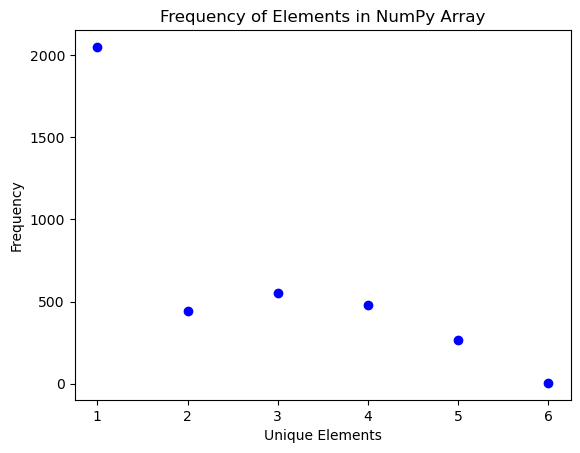

76.16662272607435

In [334]:
score('party_iban')

/tmp/ipykernel_18823/4245742792.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  count_column  = (temp.join(df_train, on=col_name, how='left').select('external_id')).join(df_train.group_by('external_id').agg(pl.count().alias('external_id_count')), on='external_id', how='left').select('external_id_count').to_numpy().flatten()


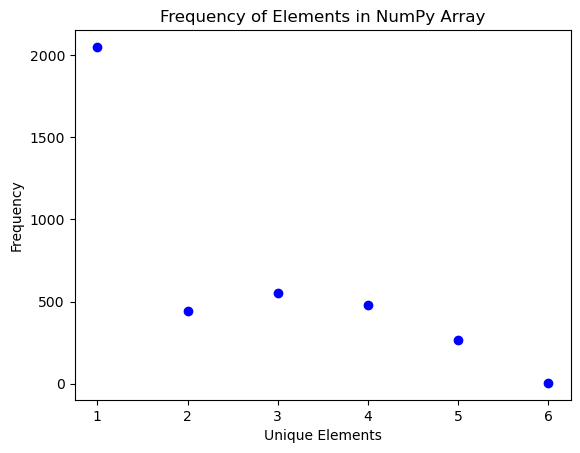

76.16662272607435

In [136]:
score('party_iban')


/tmp/ipykernel_18823/4245742792.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  count_column  = (temp.join(df_train, on=col_name, how='left').select('external_id')).join(df_train.group_by('external_id').agg(pl.count().alias('external_id_count')), on='external_id', how='left').select('external_id_count').to_numpy().flatten()


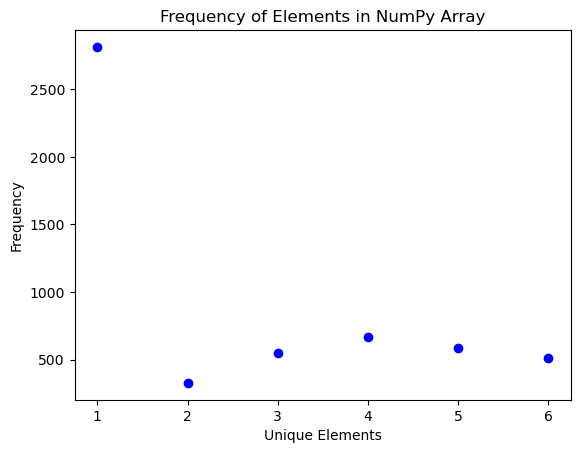

69.98350742166025

In [317]:
score('parsed_name')


In [80]:
v = ['parsed_name', 'parsed_address_street_name', 'parsed_address_street_number', 'parsed_address_unit', 'parsed_address_postal_code', 'parsed_address_city', 'parsed_address_state', 'parsed_address_country', 'party_iban', 'party_phone']


for col in v:
    print(col, score(col), sep = "--")

parsed_name--69.98350742166025
parsed_address_street_name--61.26813219679976
parsed_address_street_number--71.01408450704226
parsed_address_unit--0
parsed_address_postal_code--69.47513812154696
parsed_address_city--66.07675482203221
parsed_address_state--94.0711462450593
parsed_address_country--93.98496240601504
party_iban--76.16662272607435
party_phone--58.47641273545591


In [361]:
def purgeIBAN(df):
    df_iban_count = df.group_by('party_iban').agg(pl.len().alias('iban_count'))
    df_with_count = df.join(df_iban_count, on='party_iban', how='left')
    return df_with_count.filter(pl.col('iban_count').ne(1) | pl.col('iban_count').is_null()).select(pl.exclude('iban_count'))

def purgeName(df):
    df_iban_count = df.group_by('parsed_name').agg(pl.len().alias('name_count'))
    df_with_count = df.join(df_iban_count, on='parsed_name', how='left')
    return df_with_count.filter(pl.col('name_count').ne(1) | pl.col('name_count').is_null()).select(pl.exclude('name_count'))    
    
    

In [355]:
def purgeCombination(df):
    df_iban_count = df.group_by('party_iban').agg(pl.len().alias('iban_count'))
    df_with_iban = df.join(df_iban_count, on='party_iban', how='left')
    df_iban = df_with_iban.filter(pl.col('iban_count').eq(1))
                                   
    df_name_count = df.group_by('parsed_name').agg(pl.len().alias('name_count'))
    df_with_name = df.join(df_name_count, on='parsed_name', how='left')
    df_name = df_with_name.filter(pl.col('name_count').eq(1))

        # Get unique rows for df_name and df_iban based on the desired criteria
    df_name_filtered = df_name.select(['party_iban', 'parsed_name'])
    df_iban_filtered = df_iban.select(['party_iban', 'parsed_name'])
    
    # Find rows to delete by performing an inner join between df_name_filtered and df_iban_filtered
    rows_to_delete = df_name_filtered.join(
        df_iban_filtered, 
        on=['party_iban', 'parsed_name'], 
        how='inner'
    )
    
    # Exclude the rows_to_delete from the original dataframe
    df_filtered = df.join(
        rows_to_delete, 
        on=['party_iban', 'parsed_name'], 
        how='anti'
    )

    return df_filtered
    
    # Result: df_filtered contains rows not found in both df_name and df_iban

In [458]:
purged_df = purgeName(purgeIBAN(df_train))
# purged_df = purgeName(df_test/

In [456]:
print(purged_df.shape)

(390967, 18)


In [ ]:
purged_df.group_by(pl.col('parsed_name')).agg(pl.len().alias('count')).sort(pl.col('count'))

# Clustering and Network Structure

In [459]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

def name_embbed(df):
    all_texts = [text.split(" ") for text in df['parsed_name'].to_list()]
    
    model = Word2Vec(all_texts, vector_size=128, window=5, epochs=30,  sg=1, workers=4,min_count=1)
    
    subset_texts = df['parsed_name'].to_list()
    
    subset_text_embeddings = []
    
    for text in subset_texts:
        subset_text_embeddings.append(np.mean([model.wv[word] for word in text.split(" ")], axis=0))
    
    X_word2vec = np.vstack(subset_text_embeddings)
    return X_word2vec

In [460]:
from fuzzywuzzy import fuzz
import re

def is_close_match(a, b, threshold=60):
    return fuzz.token_sort_ratio(a, b, force_ascii=True, full_process=True) > threshold

In [461]:
def regex_filter(df):
    for col in ['parsed_name', 'parsed_address_postal_code', 'parsed_address_country', 'parsed_address_state']:
        df = df.with_columns(
            pl.col(col).str.replace_all(r'[-/_]', ' ')
        )
    return df   

filtered_df = regex_filter(purged_df)

In [467]:
X_word2vec = name_embbed(filtered_df)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.0005, min_samples=2)
clusters = dbscan.fit_predict(X_word2vec)

filtered_df = filtered_df.with_columns(pl.Series(name="true_name", values=clusters))

In [468]:
import networkx as nx

grouping_no = 1
final = []

def clustering(df: pl.DataFrame):

    global grouping_no
    # groups = df.group_by('parsed_name').agg(pl.all())
    # grouped_dict = {key: df.filter(pl.col('parsed_name') == key) for key in df['parsed_name'].unique()}
    # print(len(grouped_dict))
    for name in df['true_name'].unique():
        df2 = df.filter(pl.col('true_name') == name)

        n = df2.shape[0]
        adj_matrix = [[0 for _ in range(n)] for _ in range(n)]

        for i in range(n):
            for j in range(i+1, n):
                if df2.get_column('party_iban')[i] and df2.get_column('party_iban')[i] == df2.get_column('party_iban')[j]:
                    adj_matrix[i][j] = 1
                    adj_matrix[j][i] = 1
                elif df2.get_column('party_phone')[i] and df2.get_column('party_phone')[i] == df2.get_column('party_phone')[j]:
                    adj_matrix[i][j] = 1
                    adj_matrix[j][i] = 1 
                elif df2.get_column('parsed_address_postal_code')[i] and is_close_match(df2.get_column('parsed_address_postal_code')[i],df2.get_column('parsed_address_postal_code')[j]):
                    adj_matrix[i][j] = 1
                    adj_matrix[j][i] = 1
                elif df2.get_column('parsed_address_country')[i] and is_close_match(df2.get_column('parsed_address_country')[i],df2.get_column('parsed_address_country')[j]):
                    adj_matrix[i][j] = 1
                    adj_matrix[j][i] = 1
                elif df2.get_column('parsed_address_state')[i] and is_close_match(df2.get_column('parsed_address_state')[i],df2.get_column('parsed_address_state')[j]):
                    adj_matrix[i][j] = 1
                    adj_matrix[j][i] = 1

        G = nx.from_numpy_array(np.array(adj_matrix))
        cc = list(nx.connected_components(G))
        s = set([i for i in range(n)])
        for cluster in cc:
            for index in cluster:
                final.append([df2.get_column('transaction_reference_id')[index], grouping_no])
                s.remove(index)
            grouping_no += 1

        # # cluster for remaining 
        # if (len(s) > 1): 
        #     for index in s:
        #         final.append([df2.get_column('transaction_reference_id')[index], grouping_no])  
        #     grouping_no += 1


clustering(filtered_df)

final_df = pl.DataFrame(final, schema=["transaction_reference_id", "external_id"])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


In [445]:
final_df.write_csv('data/final_testv10.csv')


# Final Submission & Evaluation

In [291]:
def compute_score(df: pl.DataFrame) -> tuple[float, float, float]:

    tp = 0
    fp = 0
    fn = 0
    
    rows = list(df.iter_rows())
    for i in range(len(rows)):
        for j in range(i+1, len(rows)):
            if rows[i][1] == rows[j][1]:
                if rows[i][2] == rows[j][2]:
                    tp += 1
                else:
                    fp += 1
            elif rows[i][2] == rows[j][2]:
                fn += 1
    
    # Compute metrics
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    # Print metrics
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 Score:', f1 * 100, '%')
    
    return prec, rec, f1

In [469]:
x = final_df.join(df_train.select(['transaction_reference_id', 'external_id']), on='transaction_reference_id', how='left')

In [439]:
final_df.shape, x.shape

((4318, 2), (4318, 3))

In [470]:
compute_score(x)

Precision: 1.0
Recall: 0.6132683765582462
F1 Score: 76.0280664357403 %


(1.0, 0.6132683765582462, 0.760280664357403)